In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../scorewater/data/final/dtdata.csv', index_col=0)

In [2]:
new_column_names = ['section', 'Height', 'width', 'perimeter', 'Length', 'Speed',
                   'WaterHeight', 'Flow', 'section_1', 'Height_1', 'width_1', 'perimeter_1',
                   'Length_1', 'Speed_1', 'WaterHeight_1', 'Flow_1', 'section_2',
                   'Height_2', 'width_2', 'perimeter_2', 'Length_2', 'Speed_2',
                   'WaterHeight_2', 'Flow_2', 'section_3', 'Height_3', 'width_3',
                   'perimeter_3', 'Length_3', 'Speed_3', 'WaterHeight_3', 'Flow_3',
                   'section_4', 'Height_4', 'width_4', 'perimeter_4', 'Length_4',
                   'Speed_4', 'WaterHeight_4', 'Flow_4', 'section_5', 'Height_5',
                   'width_5', 'perimeter_5', 'Length_5', 'Speed_5', 'WaterHeight_5',
                   'Flow_5', 'neighborhood']

# Get the current column names
current_column_names = df.columns

# Replace the names of the last 49 columns
df.columns = current_column_names[:-49].tolist() + new_column_names
df.drop('value_2', axis=1, inplace=True)

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.base import clone
from sklearn.datasets import make_classification
import shap
import dtreeviz
from dtreeviz import decision_boundaries

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Training a tree with only the features of the section to be predicted

In [4]:
X = df.drop(df.filter(regex=("(_[0-5]_[0-5]|_[2-5])")).columns, 
        axis=1)
y= X['value_y']
X.drop(['amount_rain_std_1', 'amount_rain_mean_1', 'Height_1',
        'Length_1', 'Speed_1', 'Flow_1', 'value_y',
        'section_1', 'width_1', 'perimeter_1', 'WaterHeight_1'],
       axis=1, inplace=True)

In [5]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=4)

In [6]:
model_1 = DecisionTreeClassifier(**{'max_depth': 7, 'max_features': 0.794612916790575, 'min_samples_leaf': 12, 'min_samples_split': 19, 'random_state': 4})
model_1.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, max_features=0.794612916790575,
                       min_samples_leaf=12, min_samples_split=19,
                       random_state=4)

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix

# Predict using the best model
y_pred_test_expanded = model_1.predict(X_test)
y_prob_test_expanded = model_1.predict_proba(X_test)[:, 1]

# Compute the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test_expanded).ravel()

# Calculate the performance metrics for the test set
test_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_test_expanded),
    'Precision': precision_score(y_test, y_pred_test_expanded),
    'Recall': recall_score(y_test, y_pred_test_expanded),
    'F1 Score': f1_score(y_test, y_pred_test_expanded),
    'ROC-AUC': roc_auc_score(y_test, y_prob_test_expanded),
    'specificity': tn / (tn + fp)
}

test_metrics

{'Accuracy': 0.7643979057591623,
 'Precision': 0.6710526315789473,
 'Recall': 0.7183098591549296,
 'F1 Score': 0.6938775510204082,
 'ROC-AUC': 0.797593896713615,
 'specificity': 0.7916666666666666}

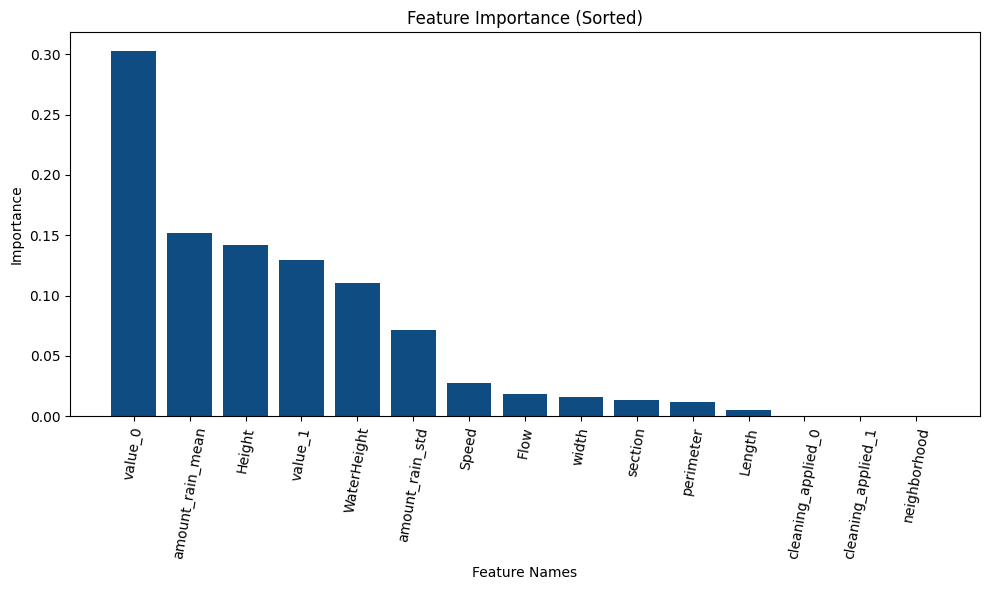

In [8]:
feature_names = X.columns
importance_values = model_1.feature_importances_

sorted_indices = sorted(range(len(importance_values)), key=lambda k: importance_values[k], reverse=True)
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_importance_values = [importance_values[i] for i in sorted_indices]

# Creating a bar plot
plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, sorted_importance_values, color='#0f4c81')
plt.xlabel('Feature Names')
plt.ylabel('Importance')
plt.title('Feature Importance (Sorted)')
plt.xticks(rotation=80)
plt.tight_layout()

# Display the plot
plt.show()

In [9]:
explainer = shap.TreeExplainer(model_1)

# Compute SHAP values
shap_values = explainer.shap_values(X)

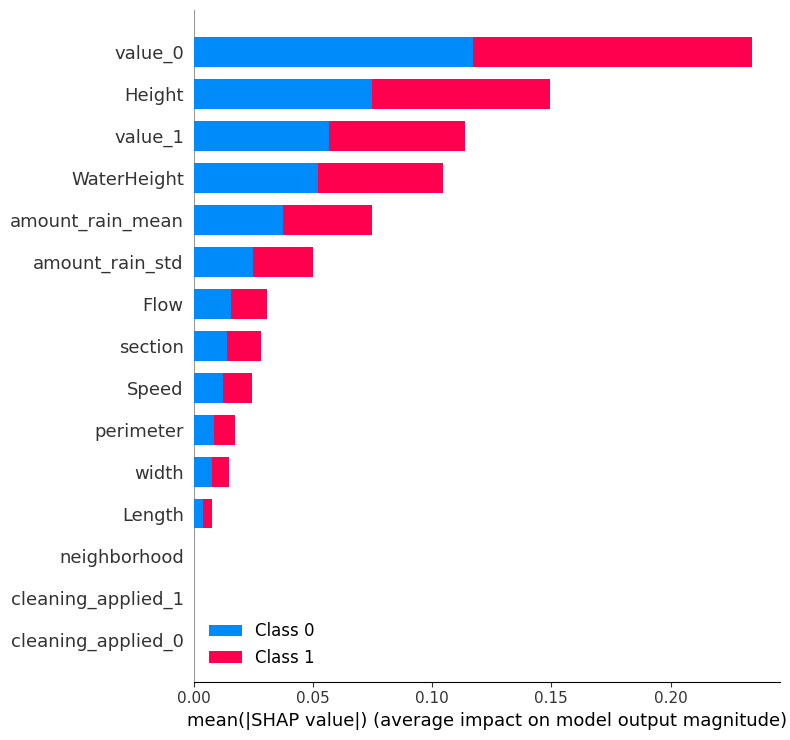

In [10]:
# Plot summary plot for overall impact of each feature on the model output
shap.summary_plot(shap_values, X, plot_type="bar")

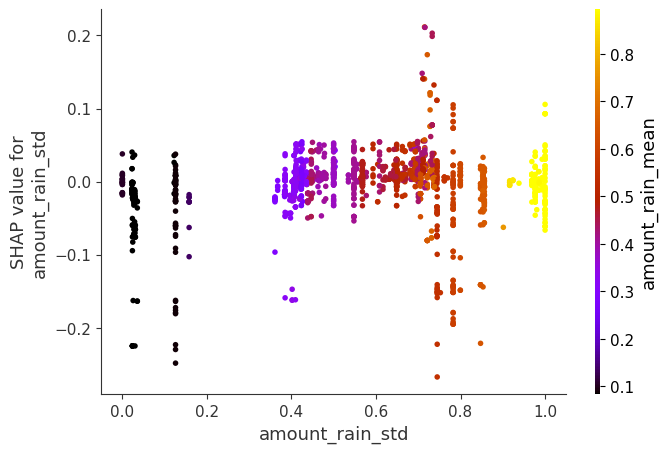

In [11]:
shap.dependence_plot(1, shap_values[0], X, feature_names= feature_names, interaction_index=0, cmap='gnuplot')
plt.show()

In [12]:
explanation = shap.Explanation(values=shap_values[0][1388], base_values=explainer.expected_value[0], feature_names=X.columns)

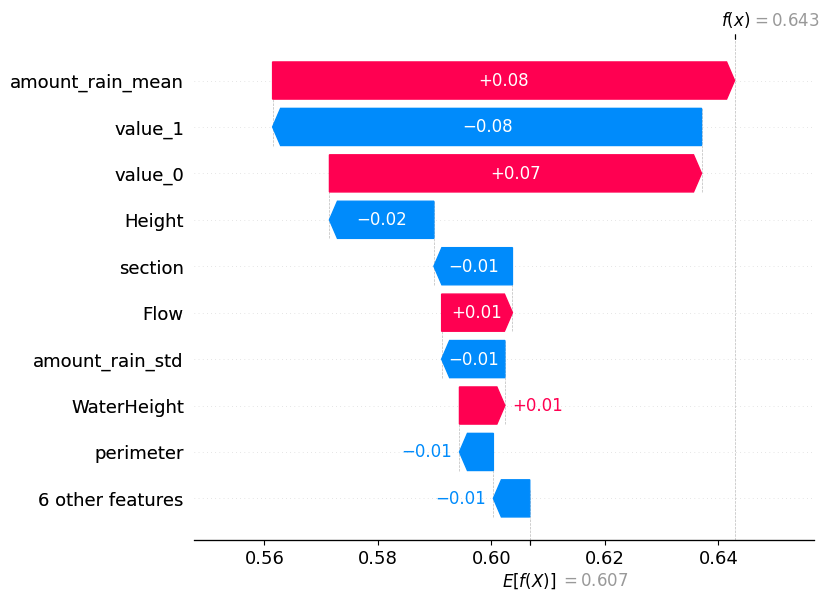

In [13]:
shap.plots.waterfall(explanation)

In [14]:
explanation = shap.Explanation(values=shap_values[0][1712], base_values=explainer.expected_value[0], feature_names=X.columns)

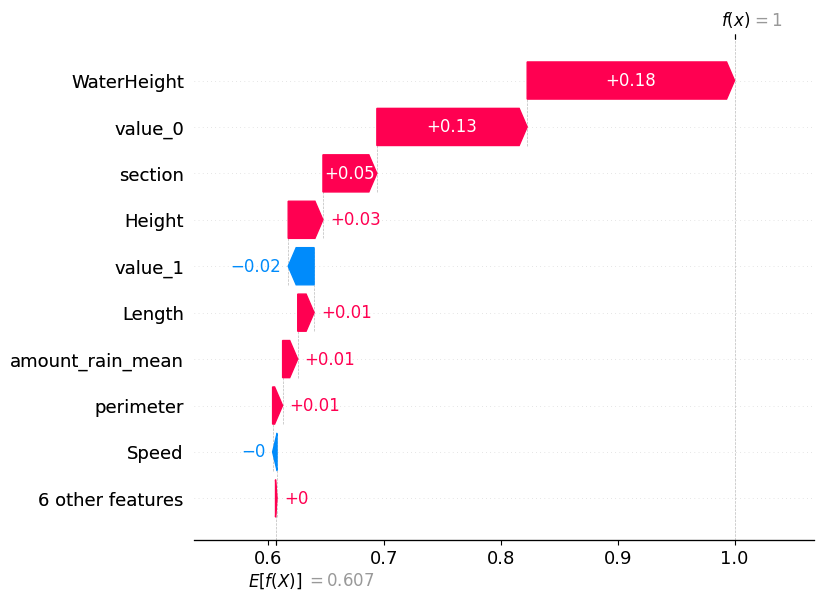

In [15]:
shap.plots.waterfall(explanation)

In [16]:
viz_model = dtreeviz.model(model_1,
                           X_train=X, 
                           y_train=y,
                           feature_names=list(X.columns),
                           target_name='value_y',
                           class_names=y.unique().astype(str))

In [17]:
X.loc[(X.amount_rain_std>0.9)&
     (X.value_1>0.05)&
     (X.Height<0.4)&
     (X.value_0<0.05)].index

Index([695, 831, 1273, 1352, 1388, 1399, 1468, 1477, 1507, 1510, 1515, 1520,
       1527],
      dtype='int64')

In [18]:
model_1.predict(X.loc[(X.amount_rain_std>0.9)&
     (X.value_1>0.05)&
     (X.Height<0.4)&
     (X.value_0<0.05)])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

/Users/marc.ribalta/anaconda3/envs/phd/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


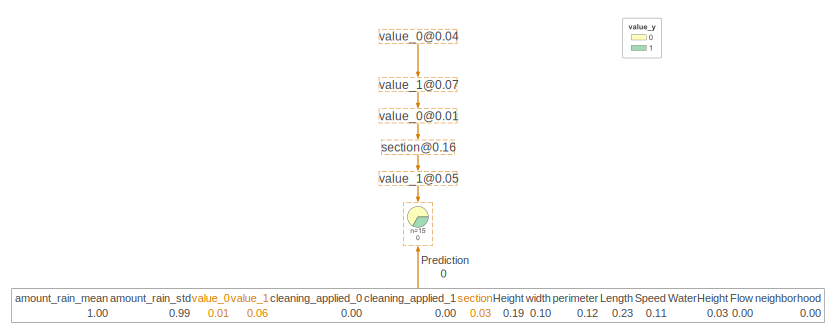

In [19]:
viz_model.view(x=X.iloc[1388], show_just_path=True, fancy=False)

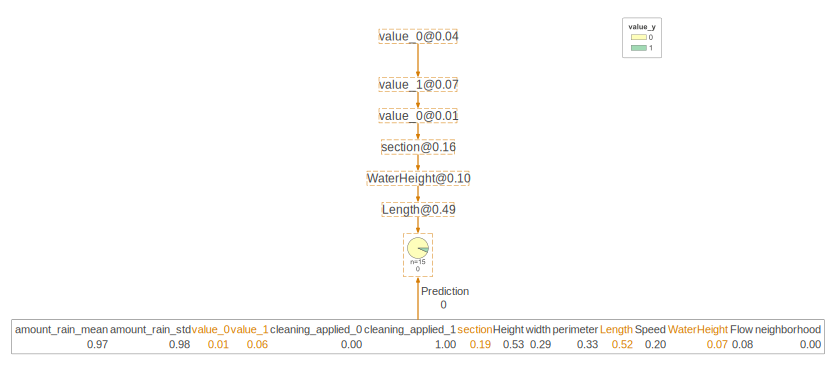

In [20]:
viz_model.view(x=X.iloc[1712], show_just_path=True, fancy=False)

In [21]:
feature_importance_dict = dict(zip(X_test.columns, model_1.feature_importances_))

# Sort the dictionary based on importances
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

sorted_feature_importance

[('value_0', 0.30300497263898774),
 ('amount_rain_mean', 0.15179453787483652),
 ('Height', 0.14170736436997908),
 ('value_1', 0.12964864791425842),
 ('WaterHeight', 0.11004458585451267),
 ('amount_rain_std', 0.07158258045239464),
 ('Speed', 0.027932678512641543),
 ('Flow', 0.018119891869438243),
 ('width', 0.016074458158538467),
 ('section', 0.013298727220416747),
 ('perimeter', 0.011948689248185982),
 ('Length', 0.004842865885809942),
 ('cleaning_applied_0', 0.0),
 ('cleaning_applied_1', 0.0),
 ('neighborhood', 0.0)]

In [23]:
import dtreeviz

viz = dtreeviz.model(
    model_1,
    X,
    y,
    target_name="value_y",  # Use 'value_y' as the target variable name
    feature_names=X.columns,
    class_names=y.unique().astype(str)
)


v = viz.view(fancy=True)  
v.show()               
v.save("best_tree_without_neighbours.svg")


v = viz.view(fancy=False)  
v.show()               
v.save("best_tree_without_neighbours_unfancy.svg")

/Users/marc.ribalta/anaconda3/envs/phd/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


# Best possible decision tree

The idea is to get the best possible tree, hyperparameter and feature - wise.

In [24]:
X = df.drop(columns=['value_y'])
y = df['value_y']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [25]:
best_features_global = ['amount_rain_std', 'value_1_5', 'value_1_3', 'value_1_2', 'Height', 'value_1', 'Speed', 'amount_rain_mean_1', 'Length_1']

In [26]:
model_2 = DecisionTreeClassifier(**{'max_depth': 16, 'max_features': 0.9360168327534356, 'min_samples_leaf': 5, 'min_samples_split': 11, 'random_state': 4})
model_2.fit(X_train[best_features_global], y_train)

DecisionTreeClassifier(max_depth=16, max_features=0.9360168327534356,
                       min_samples_leaf=5, min_samples_split=11,
                       random_state=4)

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix

# Predict using the best model
y_pred_test_expanded = model_2.predict(X_test[best_features_global])
y_prob_test_expanded = model_2.predict_proba(X_test[best_features_global])[:, 1]

# Compute the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test_expanded).ravel()

# Calculate the performance metrics for the test set
test_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_test_expanded),
    'Precision': precision_score(y_test, y_pred_test_expanded),
    'Recall': recall_score(y_test, y_pred_test_expanded),
    'F1 Score': f1_score(y_test, y_pred_test_expanded),
    'ROC-AUC': roc_auc_score(y_test, y_prob_test_expanded),
    'specificity': tn / (tn + fp)
}

test_metrics

{'Accuracy': 0.7801047120418848,
 'Precision': 0.7341772151898734,
 'Recall': 0.7341772151898734,
 'F1 Score': 0.7341772151898734,
 'ROC-AUC': 0.7971858047016276,
 'specificity': 0.8125}

no neigh

```
{'Accuracy': 0.7643979057591623,
 'Precision': 0.6710526315789473,
 'Recall': 0.7183098591549296,
 'F1 Score': 0.6938775510204082,
 'ROC-AUC': 0.797593896713615,
  'specificity': 0.7916666666666666}
 ```

neigh
```
{'Accuracy': 0.7801047120418848,
 'Precision': 0.7341772151898734,
 'Recall': 0.7341772151898734,
 'F1 Score': 0.7341772151898734,
 'ROC-AUC': 0.7971858047016276,
  'specificity': 0.8125}
```

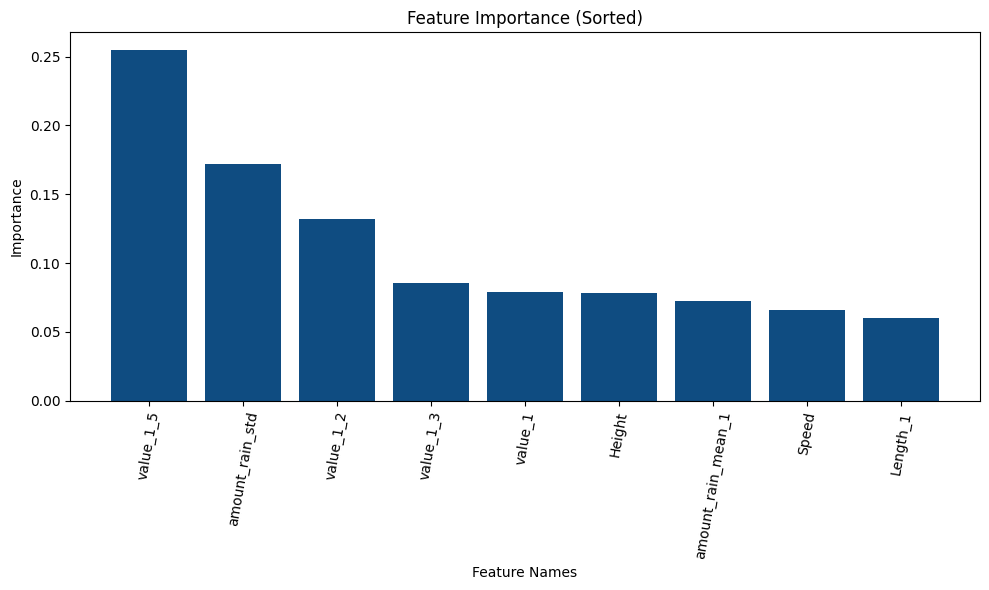

In [28]:
feature_names = best_features_global
importance_values = model_2.feature_importances_

sorted_indices = sorted(range(len(importance_values)), key=lambda k: importance_values[k], reverse=True)
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_importance_values = [importance_values[i] for i in sorted_indices]

# Creating a bar plot
plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, sorted_importance_values, color='#0f4c81')
plt.xlabel('Feature Names')
plt.ylabel('Importance')
plt.title('Feature Importance (Sorted)')
plt.xticks(rotation=80)
plt.tight_layout()

# Display the plot
plt.show()

In [29]:
explainer = shap.TreeExplainer(model_2)

# Compute SHAP values
shap_values = explainer.shap_values(X[best_features_global].values)

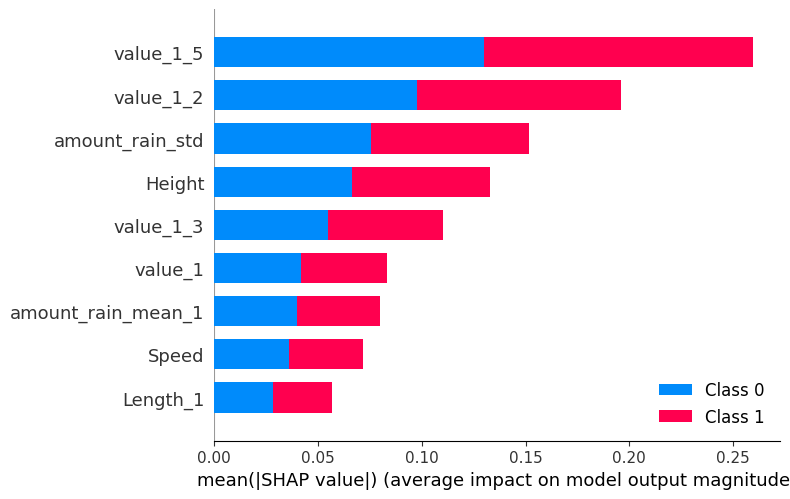

In [30]:
# Plot summary plot for overall impact of each feature on the model output
shap.summary_plot(shap_values, X_test[best_features_global], plot_type="bar")

In [31]:
explanation = shap.Explanation(values=shap_values[0][1388], base_values=explainer.expected_value[0], feature_names=best_features_global)

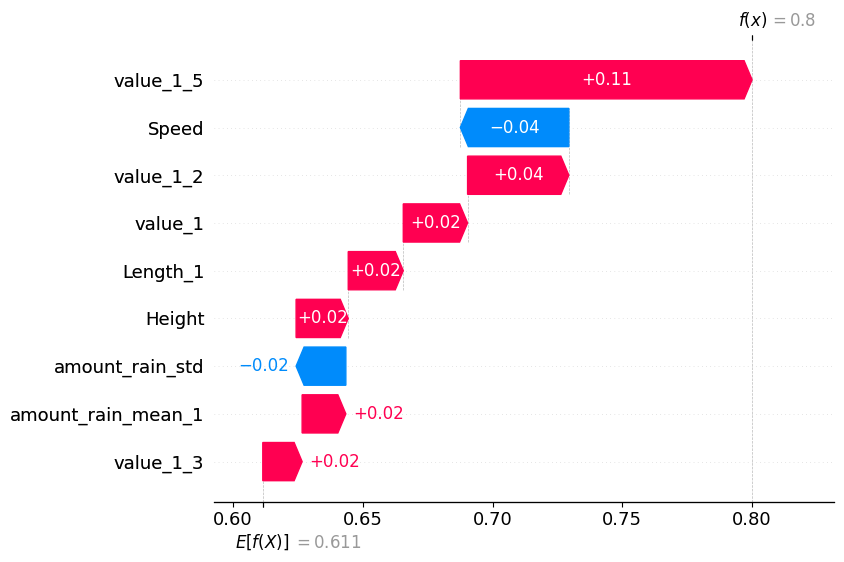

In [32]:
shap.plots.waterfall(explanation)

In [33]:
explanation = shap.Explanation(values=shap_values[0][1712], base_values=explainer.expected_value[0], feature_names=best_features_global)

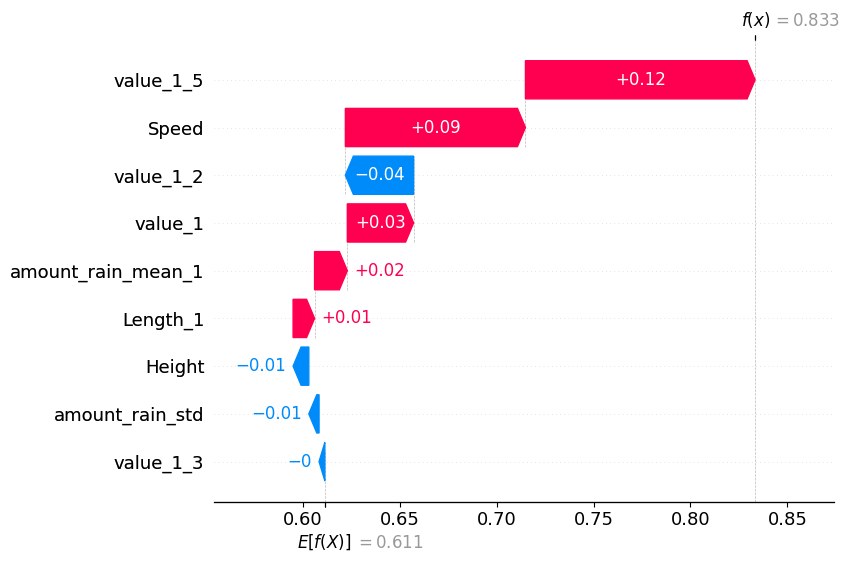

In [34]:
shap.plots.waterfall(explanation)

In [35]:
X.loc[(X.amount_rain_std>0.9)&
     (X.value_1>0.05)&
     (X.Height>0.5)&
     (X.value_0<0.05)].index

Index([1661, 1667, 1673, 1712], dtype='int64')

In [36]:
model_2.predict(X.loc[(X.amount_rain_std>0.9)&
     (X.value_1>0.05)&
     (X.Height>0.5)&
     (X.value_0<0.05), best_features_global])

array([0, 0, 0, 0])

In [37]:
viz_model = dtreeviz.model(model_2,
                           X_train=X[best_features_global], 
                           y_train=y,
                           feature_names=list(best_features_global),
                           target_name='value_y',
                           class_names=y.unique().astype(str))

/Users/marc.ribalta/anaconda3/envs/phd/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


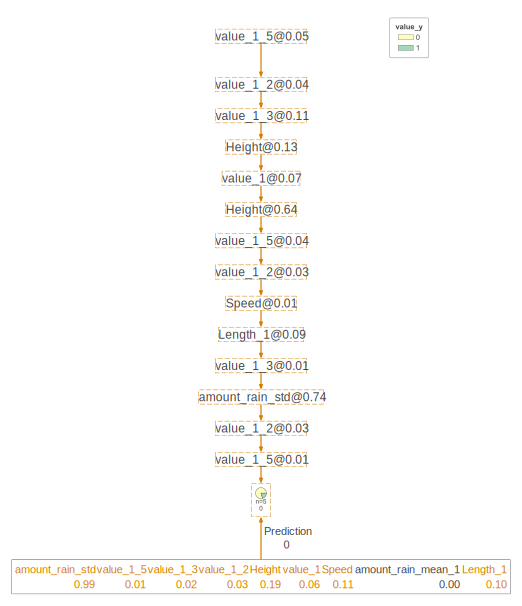

In [38]:
viz_model.view(x=X.iloc[1388][best_features_global], show_just_path=True, fancy=False)

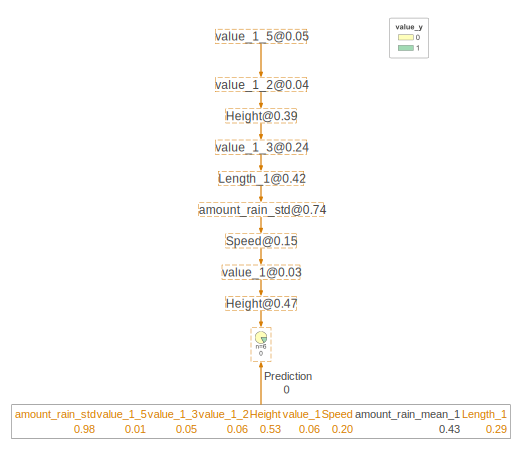

In [39]:
viz_model.view(x=X.iloc[1712][best_features_global], show_just_path=True, fancy=False)

In [40]:
df.iloc[1388].value_y

0.0

In [41]:
df.iloc[1399].value_y

1.0

In [42]:
feature_importance_dict = dict(zip(best_features_global, model_2.feature_importances_))

# Sort the dictionary based on importances
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

sorted_feature_importance

[('value_1_5', 0.2548602635604452),
 ('amount_rain_std', 0.1722092753955686),
 ('value_1_2', 0.1320668579889779),
 ('value_1_3', 0.0855812479462179),
 ('value_1', 0.07881997054313085),
 ('Height', 0.0779586156972797),
 ('amount_rain_mean_1', 0.07242735248923371),
 ('Speed', 0.0657759518721392),
 ('Length_1', 0.06030046450700688)]

In [44]:
import dtreeviz

viz = dtreeviz.model(
    model_2,
    X[best_features_global],
    y,
    target_name="value_y",  # Use 'value_y' as the target variable name
    feature_names=best_features_global,
    class_names=y.unique().astype(str)
)


v = viz.view(fancy=True)  
v.show()               
v.save("best_tree.svg")

v = viz.view(fancy=False)
v.show()               
v.save("best_tree_unfancy.svg")

/Users/marc.ribalta/anaconda3/envs/phd/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
